# Bericht Projektlabor Maschinelles Lernen (PML)

|Gruppenmitglied|Matrikelnummer|
|---|---|
|Christian Singer|?|
|Domenic Gosein|002160647|
|Lukas Burger|?|
|Maximilian Kürschner|?|

Dozent: Dr.-Ing. Wei Yap Tan  

Fakultät der Informationstechnik  

Hochschule Mannheim  
Wintersemester 2021/22  

## Inhalt

1. Einleitung
2. Kalman Filter für den 1D Radarsensor
3. Experiment für den 1D Radarsensor
4. DBSCAN für den 3D Radarsensor
5. Kalman Filter für den 3D Radarsensor
6. Experiment für den 3D Radarsensor
7. Schlussfolgerung
8. Ausblick
9. Verwendete Literatur
10. Anhang

## Einleitung

Nach einer Einführung in maschinelles Lernen, war es unsere Aufgabe das Kalman Filter und den DBSCAN Algorithmus für Daten aus einem 1D und anschließend 3D Radarsensor zu implementieren.  

In [206]:
# Folgender Code muss zu Beginn des Notebooks ausgeführt werden,
# er importiert alle notwendigen Bibliotheken.
import numpy as np
import copy
import matplotlib.pyplot as plt
from collections import deque

## 1D Radarsensor

In diesem Abschnitt befinden sich Simulation, Kalman Filter und Experiment für den 1D Radarsensor.

### 1D-Radar-Sensor Simulation

Die Simulation für den 1D Radarsensor gibt uns die Wahl zwischen fünf verschiedenen Bewegungsarten: Static, Constant Velocity, Constant Acceleration, Sinus und Triangle, sowie die Möglichkeit einen Sporadic Error zu den Sensordaten hinzuzufügen.  
Zudem lassen sich an dieser Stelle die Sensor Eigenschaften anspassen.

In [207]:
minRange = 0.3  # m
maxRange = 25.0  # m
maxVelocity = 25  # m/s --> 90 km/h
rangeAccuracy = 0.02  # m
velocityAccuracy = 0.005  # m/s
measurementRate = 100  # Hz

In [208]:
def GenerateData(type="Static", options={}):

    # static
    if(type == "Static"):
        # sanity check
        if(("initialDistance" in options) == False) \
                or (("stopTime" in options) == False):
            return None, None

        timeAxis = np.arange(0, options["stopTime"], 0.01/measurementRate)
        distValues = options["initialDistance"] * \
            np.ones(np.shape(timeAxis))
        truthDistValues = copy.copy(distValues)

        distValues += np.random.uniform(-1*rangeAccuracy,
                                           rangeAccuracy, np.shape(timeAxis))
        velValues = np.zeros(np.shape(timeAxis))
        truthVelValues = copy.copy(velValues)

        velValues += np.random.uniform(-1*velocityAccuracy,
                                          velocityAccuracy, np.shape(timeAxis))
        velValues[distValues > maxRange] = np.NaN
        distValues[distValues > maxRange] = np.NaN
        velValues[distValues < minRange] = np.NaN
        distValues[distValues < minRange] = np.NaN        
        velValues[velValues > maxVelocity] = np.NaN
        velValues[velValues < -1 * maxVelocity] = np.NaN

        # decimate to actual measurement rate
        timeAxis = timeAxis[0::100]
        distValues = distValues[0::100]
        velValues = velValues[0::100]
        truthDistValues = truthDistValues[0::100]
        truthVelValues = truthVelValues[0::100]
    
        if("SporadicError" in options):
            rng = np.random.default_rng()
            ind = rng.choice(np.size(timeAxis), size=options["SporadicError"], replace=False)

            distValues[ind] = np.random.uniform(minRange,
                                           maxRange, np.shape(ind))

            velValues[ind] = np.random.uniform(-1*maxVelocity,
                                           maxVelocity, np.shape(ind))

        return timeAxis, distValues, velValues, truthDistValues, truthVelValues

    # constant velocity
    if(type == "ConstantVelocity"):
        # sanity check
        if(("initialDistance" in options) == False) \
                or (("stopTime" in options) == False) \
                or (("velocity" in options) == False):
            return None, None

        timeAxis = np.arange(0, options["stopTime"], 0.01/measurementRate)

        distValues = options["initialDistance"] + options["velocity"]*timeAxis
        truthDistValues = copy.copy(distValues)

        distValues += np.random.uniform(-1*rangeAccuracy,
                                           rangeAccuracy, np.shape(timeAxis))

        velValues = options["velocity"] * np.ones(np.shape(timeAxis))
        truthVelValues = copy.copy(velValues)

        velValues += np.random.uniform(-1*velocityAccuracy,
                                          velocityAccuracy, np.shape(timeAxis))
        velValues[distValues > maxRange] = np.NaN
        distValues[distValues > maxRange] = np.NaN
        velValues[distValues < minRange] = np.NaN
        distValues[distValues < minRange] = np.NaN
        velValues[velValues > maxVelocity] = np.NaN
        velValues[velValues < -1 * maxVelocity] = np.NaN
        
        # decimate to actual measurement rate
        timeAxis = timeAxis[0::100]
        distValues = distValues[0::100]
        velValues = velValues[0::100]
        truthDistValues = truthDistValues[0::100]
        truthVelValues = truthVelValues[0::100]
    
        if("SporadicError" in options):
            rng = np.random.default_rng()
            ind = rng.choice(np.size(timeAxis), size=options["SporadicError"], replace=False)

            distValues[ind] = np.random.uniform(minRange,
                                           maxRange, np.shape(ind))

            velValues[ind] = np.random.uniform(-1*maxVelocity,
                                           maxVelocity, np.shape(ind))

        return timeAxis, distValues, velValues

    # constant acceleration
    if(type == "ConstantAcceleration"):
        # sanity check
        if(("initialDistance" in options) == False) \
                or (("stopTime" in options) == False) \
                or (("initialVelocity" in options) == False) \
                or (("acceleration" in options) == False):
            return None, None

        timeAxis = np.arange(0, options["stopTime"], 0.01/measurementRate)

        velValues = options["initialVelocity"] + \
            options["acceleration"] * timeAxis
        distValues = options["initialDistance"] + 0.5 * \
            options["acceleration"] * timeAxis * timeAxis

        truthVelValues = copy.copy(velValues)
        truthDistValues = copy.copy(distValues)

        velValues += np.random.uniform(-1*velocityAccuracy,
                                          velocityAccuracy, np.shape(timeAxis))
        distValues += np.random.uniform(-1*rangeAccuracy,
                                           rangeAccuracy, np.shape(timeAxis))

        velValues[distValues > maxRange] = np.NaN
        distValues[distValues > maxRange] = np.NaN
        velValues[distValues < minRange] = np.NaN
        distValues[distValues < minRange] = np.NaN
        velValues[velValues > maxVelocity] = np.NaN
        velValues[velValues < -1 * maxVelocity] = np.NaN
        
        # decimate to actual measurement rate
        timeAxis = timeAxis[0::100]
        distValues = distValues[0::100]
        velValues = velValues[0::100]
        truthDistValues = truthDistValues[0::100]
        truthVelValues = truthVelValues[0::100]
    
        if("SporadicError" in options):
            rng = np.random.default_rng()
            ind = rng.choice(np.size(timeAxis), size=options["SporadicError"], replace=False)

            distValues[ind] = np.random.uniform(minRange,
                                           maxRange, np.shape(ind))

            velValues[ind] = np.random.uniform(-1*maxVelocity,
                                           maxVelocity, np.shape(ind))

        return timeAxis, distValues, velValues, truthDistValues, truthVelValues

    # sinus movement
    if(type == "Sinus"):
        # sanity check
        if(("initialDistance" in options) == False) \
                or (("stopTime" in options) == False) \
                or (("movementRange" in options) == False) \
                or (("frequency" in options) == False):
            return None, None

        timeAxis = np.arange(0, options["stopTime"], 0.01/measurementRate)

        distValues = options["initialDistance"] + options["movementRange"] * \
            np.sin(2*np.pi*options["frequency"]*timeAxis)

        truthDistValues = copy.copy(distValues)

        velValues = 2*np.pi*options["frequency"] * options["movementRange"] * np.cos(
            2*np.pi*options["frequency"]*timeAxis)

        truthVelValues = copy.copy(velValues)

        velValues += np.random.uniform(-1*velocityAccuracy,
                                          velocityAccuracy, np.shape(timeAxis))
        distValues += np.random.uniform(-1*rangeAccuracy,
                                           rangeAccuracy, np.shape(timeAxis))

        velValues[distValues > maxRange] = np.NaN
        distValues[distValues > maxRange] = np.NaN
        velValues[distValues < minRange] = np.NaN
        distValues[distValues < minRange] = np.NaN
        velValues[velValues > maxVelocity] = np.NaN
        velValues[velValues < -1 * maxVelocity] = np.NaN
        
        # decimate to actual measurement rate
        timeAxis = timeAxis[0::100]
        distValues = distValues[0::100]
        velValues = velValues[0::100]
        truthDistValues = truthDistValues[0::100]
        truthVelValues = truthVelValues[0::100]
    
        if("SporadicError" in options):
            rng = np.random.default_rng()
            ind = rng.choice(np.size(timeAxis), size=options["SporadicError"], replace=False)

            distValues[ind] = np.random.uniform(minRange,
                                           maxRange, np.shape(ind))

            velValues[ind] = np.random.uniform(-1*maxVelocity,
                                           maxVelocity, np.shape(ind))

        return timeAxis, distValues, velValues, truthDistValues, truthVelValues

    # triangle movement
    if(type == "Triangle"):
        # sanity check
        if(("initialDistance" in options) == False) \
                or (("stopTime" in options) == False) \
                or (("movementRange" in options) == False) \
                or (("frequency" in options) == False):
            return None, None

        timeAxis = np.arange(0, options["stopTime"], 0.01/measurementRate)

        distValues = np.zeros(np.shape(timeAxis))
        velValues = np.zeros(np.shape(timeAxis))

        for i in range(np.size(timeAxis)):
            t = timeAxis[i]
            while (t > 1/options["frequency"]):
                t = t - 1/options["frequency"]

            if (t <= 1/(2*options["frequency"])):
                if(i == 0):
                    distValues[i] = options["initialDistance"] + (2 * options["frequency"] * options["movementRange"])*0.01/measurementRate
                else:
                    distValues[i] = distValues[i-1] + (2 * options["frequency"] * options["movementRange"])*0.01/measurementRate
                
                velValues[i] = 2 * options["frequency"] * options["movementRange"]   
            else:
                distValues[i] = distValues[i-1] - (2 * options["frequency"] * options["movementRange"])*0.01/measurementRate
                velValues[i] = -2 * options["frequency"] * options["movementRange"]   

        truthDistValues = copy.copy(distValues)
        truthVelValues = copy.copy(velValues)

        velValues += np.random.uniform(-1*velocityAccuracy,
                                          velocityAccuracy, np.shape(timeAxis))
        distValues += np.random.uniform(-1*rangeAccuracy,
                                           rangeAccuracy, np.shape(timeAxis))

        velValues[distValues > maxRange] = np.NaN
        distValues[distValues > maxRange] = np.NaN
        velValues[distValues < minRange] = np.NaN
        distValues[distValues < minRange] = np.NaN
        velValues[velValues > maxVelocity] = np.NaN
        velValues[velValues < -1 * maxVelocity] = np.NaN
        # decimate to actual measurement rate
        timeAxis = timeAxis[0::100]
        distValues = distValues[0::100]
        velValues = velValues[0::100]
        truthDistValues = truthDistValues[0::100]
        truthVelValues = truthVelValues[0::100]
    
        if("SporadicError" in options):
            rng = np.random.default_rng()
            ind = rng.choice(np.size(timeAxis), size=options["SporadicError"], replace=False)

            distValues[ind] = np.random.uniform(minRange,
                                           maxRange, np.shape(ind))

            velValues[ind] = np.random.uniform(-1*maxVelocity,
                                           maxVelocity, np.shape(ind))

        return timeAxis, distValues, velValues, truthDistValues, truthVelValues

    else:
        return 0, 0

## Q Matrix Noise

In [209]:
from numpy import zeros, vstack, eye, array
from numpy.linalg import inv
from scipy.linalg import expm, block_diag

def order_by_derivative(Q, dim, block_size):
    N = dim * block_size

    D = zeros((N, N))

    Q = array(Q)
    for i, x in enumerate(Q.ravel()):
        f = eye(block_size) * x

        ix, iy = (i // dim) * block_size, (i % dim) * block_size
        D[ix:ix+block_size, iy:iy+block_size] = f

    return D

def Q_discrete_white_noise(dim, dt=1., var=1., block_size=1, order_by_dim=True):
    if dim not in [2, 3, 4]:
        raise ValueError("dim must be between 2 and 4")

    if dim == 2:
        Q = [[.25*dt**4, .5*dt**3],
             [ .5*dt**3,    dt**2]]
    elif dim == 3:
        Q = [[.25*dt**4, .5*dt**3, .5*dt**2],
             [ .5*dt**3,    dt**2,       dt],
             [ .5*dt**2,       dt,        1]]
    else:
        Q = [[(dt**6)/36, (dt**5)/12, (dt**4)/6, (dt**3)/6],
             [(dt**5)/12, (dt**4)/4,  (dt**3)/2, (dt**2)/2],
             [(dt**4)/6,  (dt**3)/2,   dt**2,     dt],
             [(dt**3)/6,  (dt**2)/2 ,  dt,        1.]]

    if order_by_dim:
        return block_diag(*[Q]*block_size) * var
    return order_by_derivative(array(Q), dim, block_size) * var

# Q_discrete_white_noise(dim=3, dt=1., var=0.01)

### Kalman Filter für den 1D Radarsensor

Die Klasse des Kalman Filter besteht aus zwei Funktionen, einer`__init__` Funktion zur Initialisierung der Klasse und einer `step` Funktion, die den Kalman Algorithmus implementiert.

In [210]:
class KalmanFilter:
    # Initialisierung von Kalman Filter
    def __init__(self, s_hat, transition_model, H, Q, R):
        self.s_hat = s_hat
        self.P_hat = np.eye(len(s_hat)) * 100
        self.model = transition_model
        self.H = H # Measurement Function
        self.Q = Q # Process Noise
        self.R = R # Measurement Noise.
        pass

    def step(self,z):
        # Prediction
        s_hat_p = self.model @ self.s_hat
        P_hat_p = self.model @ self.P_hat @ self.model.T +  self.Q
        # Calculate Kalman Matrix
        K = P_hat_p @ self.H.T @ np.linalg.inv(self.H @ P_hat_p @ self.H.T + self.R)
        # Update covariance of estimation error
        self.P_hat = self.P_hat - K @ self.H @ self.P_hat
        # Improve estimate
        e_m_p = z - self.H @ s_hat_p
        self.s_hat = s_hat_p + K @ e_m_p
        return self.s_hat

### Experiment für den 1D Radarsensor

In unserem Experiment für die Daten aus dem eindimensionalen Radarsensor haben wir nachfolgend alle Bewegungsarten simuliert und an das Kalman Filter übergeben.

#### Verhalten und Beschreibung für Static

![1DExpStatic](RadarSensor1D/1DExpStatic.png)

#### Verhalten und Beschreibung für Static mit Sporadic Error

![1DExpStaticEr](RadarSensor1D/1DExpStaticEr.png)

#### Verhalten und Beschreibung für ..



#### Verhalten und Beschreibung für .. mit Sporadic Error




Wenn das Jupyter Notebook ausgeführt wird, können die nachfolgenden Parameter beliebig angepasst werden, um eine Simulation mit dem Kalman Filter auszuprobieren.

In [211]:
# Optionen für die Simulation
opt = {
    "initialDistance": 8,
    "stopTime": 1,
    # "velocity": 3,
    # "SporadicError": 2
     "initialVelocity": 3,
     "acceleration": 1,
    # "movementRange": 1,
    # "frequency": 2,
    # "SporadicError": 2
    }

# timeAxis, distValues, velValues = GenerateData(type="ConstantVelocity", options=opt)
timeAxis, distValues, velValues, truthDistValues, truthVelValues = GenerateData(type="ConstantAcceleration", options=opt)

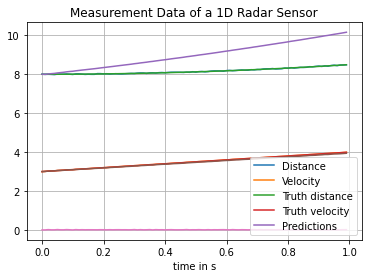

In [212]:
R = np.diag([rangeAccuracy**2, velocityAccuracy**2])/3
Q = Q_discrete_white_noise(dim=3, dt=1., var=0.01)
s0 = np.array([distValues[0], velValues[0], 0])
transition_model = np.array([[1, 0.01, 0.01/2],
                             [0, 1, 0.01],
                             [0, 0, 0.01]])
H =  np.array([[1., 0., 0.],
               [0., 1., 0.]])

KalmanFilter = KalmanFilter(s0, transition_model, H, Q, R)

Predictions = [s0]
for i in range(1,np.size(timeAxis)):
    s = np.array([distValues[i], velValues[i]])
    pred = KalmanFilter.step(s)
    Predictions.append(pred)

plt.figure()
plt.plot(timeAxis, distValues)
plt.plot(timeAxis, velValues)
plt.plot(timeAxis, truthDistValues)
plt.plot(timeAxis, truthVelValues)
plt.plot(timeAxis, Predictions)
plt.xlabel("time in s")
plt.legend(["Distance", "Velocity", "Truth distance", "Truth velocity", "Predictions"])
plt.title("Measurement Data of a 1D Radar Sensor")
plt.grid(True)
plt.show()

# Um wie viel hat sich die Messgenauigkeit verbessert?
# Wie beeinflussen die Schätzung der Kovarianzmatrix Q und R die Genauigkeit
# Fügen Sie zufällige Messfehler mit der Parameter "SporadicError" hinzu, wie verhält sich das Kalman Filter?


## 3D Radarsensor

### 3D-Radar-Sensor Simulation

In [213]:
minRange = 0.3  # m
maxRange = 25.0  # m
maxVelocity = 25  # m/s --> 90 km/h
rangeAccuracy = 0.05  # m
velocityAccuracy = 0.005  # m/s
measurementRate = 30  # Hz
sensorPosition = np.array([0,0,0.8]) # x,y,z-coordinate of the sensor

In [214]:
class Target:
    def __init__(self, opt):
        self.ValidateOption(opt)
        self.currentPosition = self.opt['InitialPosition']
        self.Trajectory = [self.opt['InitialPosition']]
        self.velocityVector = np.zeros((3,))
        self.pathCounter = 0  
        self.reachedEnd = False      

    def ValidateOption(self, opt):
        if(('InitialPosition' in opt) == False):
            raise Exception("Missing value for 'InitialPosition'")
        else:
            if(type(opt['InitialPosition']) is not np.ndarray):
                raise Exception("InitialPosition should be a np.ndarray with the shape (3,).")
            else:
                if(np.shape(opt['InitialPosition']) != (3,)):
                    raise Exception("InitialPosition should be a np.ndarray with the shape (3,).")

        if(('Path' in opt) == False):
            raise Exception("Missing value for 'Path'")
        else:
            if(type(opt['Path']) is not np.ndarray):
                raise Exception("Path should be a np.ndarray with the shape (3,n).")
            else:
                if(np.size(opt['Path'],0) != 3):
                    raise Exception("Path should be a np.ndarray with the shape (3,n).")

        if(('Velocities' in opt) == False):
            raise Exception("Missing value for 'Velocities'")
        else:
            if(type(opt['Velocities']) is not np.ndarray):
                raise Exception("Velocities should be a np.ndarray with the shape (1,n).")
            else:
                if(np.size(opt['Velocities'],0) != 1):
                    raise Exception("Velocities should be a np.ndarray with the shape (1,n).")

                if(np.size(opt['Velocities'],1) != np.size(opt['Path'],1)):
                    raise Exception("Velocities and Path should have the same length.")

        self.opt = opt

    def Step(self, deltaTime):
        # check if we are at the end
        if(self.pathCounter > np.size(self.opt['Path'],1) - 1):
            self.reachedEnd = True
            return self.currentPosition, self.velocityVector
                
        velocityVector = self.__GetVelocityVector(self.currentPosition, self.opt['Path'][:, self.pathCounter], self.opt['Velocities'][0, self.pathCounter])

        # try to step
        nextPosition = self.currentPosition + velocityVector * deltaTime

        # now check if we are within the next path target
        if(np.linalg.norm(nextPosition - self.currentPosition) < np.linalg.norm(self.opt['Path'][:, self.pathCounter] - self.currentPosition)):
            self.currentPosition = nextPosition
            self.Trajectory.append(nextPosition)
            self.velocityVector = velocityVector
            return self.currentPosition, self.velocityVector

        else: # we have to microstep
            # get the time to current path target
            countDown = deltaTime
            stepFurther = True
            while(stepFurther == True):
                microtime = (np.linalg.norm(self.opt['Path'][:, self.pathCounter] - self.currentPosition)/np.linalg.norm(nextPosition - self.currentPosition)) * countDown
                resttime = countDown - microtime

                if(self.pathCounter + 1 == np.size(self.opt['Path'],1)):
                    stepFurther == False
                    self.pathCounter = self.pathCounter + 1
                    self.velocityVector = np.zeros((3,))
                    self.currentPosition = self.opt['Path'][:, self.pathCounter - 1]
                    self.reachedEnd = True
                    return self.currentPosition, self.velocityVector

                velocityVector = self.__GetVelocityVector(self.opt['Path'][:, self.pathCounter], self.opt['Path'][:, self.pathCounter + 1], self.opt['Velocities'][:, self.pathCounter + 1])
                # try to step
                nextPosition = self.opt['Path'][:, self.pathCounter] + velocityVector * resttime

                if(np.linalg.norm(nextPosition - self.opt['Path'][:, self.pathCounter]) < np.linalg.norm(self.opt['Path'][:, self.pathCounter + 1] - self.opt['Path'][:, self.pathCounter])):
                    stepFurther = False 

                # we proceed to next path target
                self.pathCounter = self.pathCounter + 1

            self.velocityVector = velocityVector
            self.currentPosition = nextPosition
            self.Trajectory.append(nextPosition)
            return self.currentPosition, self.velocityVector

    def __GetVelocityVector(self, Position1, Position2, Velocity):
        targetPosition = Position2
        movementDirection = targetPosition - Position1
        movementDirection = movementDirection / np.linalg.norm(movementDirection)

        return Velocity * movementDirection
    
class RadarSensor:
    def __init__(self, opt):
        self.ValidateOption(opt)
        opt['MinRange'] = minRange
        opt['MaxRange'] = maxRange
        opt['MaxVelocity'] = maxVelocity
        opt['RangeAccuracy'] = rangeAccuracy
        opt['VelocityAccuracy'] = velocityAccuracy
        opt['MeasurementRate'] = 30

    def ValidateOption(self, opt):
        if(('Position' in opt) == False):
            raise Exception("Missing value for 'Position'")
        else:
            if(type(opt['Position']) is not np.ndarray):
                raise Exception("Position should be a np.ndarray with the shape (3,).")
            else:
                if(np.shape(opt['Position']) != (3,)):
                    raise Exception("Position should be a np.ndarray with the shape (3,).")

        if(('OpeningAngle' in opt) == False):
            raise Exception("Missing value for 'OpeningAngle'")
        else:
            if(type(opt['OpeningAngle']) is not np.ndarray):
                raise Exception("OpeningAngle should be a np.ndarray with the shape (2,).")
            else:
                if(np.size(opt['OpeningAngle'],0) != 2):
                    raise Exception("OpeningAngle should be a np.ndarray with the shape (2,).")

        self.opt = opt

    def Detect(self, targets):
        if len(targets) == 0:
            return None

        # initiate list
        detections = []

        # looping through targets
        for target in targets:
            visibleHor = False
            visibleVer = False
            
            # check horizontal angle
            horAngle = np.rad2deg(np.arctan((target.currentPosition[0] - self.opt['Position'][0])/(target.currentPosition[1] - self.opt['Position'][1])))
            if(np.abs(horAngle) < self.opt['OpeningAngle'][0]/2.0):
                visibleHor = True

            # check vertical angle
            verAngle = np.rad2deg(np.arctan((target.currentPosition[2] - self.opt['Position'][2])/(target.currentPosition[1] - self.opt['Position'][1])))
            if(np.abs(verAngle) < self.opt['OpeningAngle'][1]/2.0):
                visibleVer = True

            # if target visible
            if(visibleVer == True and visibleHor == True):            
                currPos = target.currentPosition - self.opt['Position']

                if(np.linalg.norm(currPos) > self.opt['MinRange'] and np.linalg.norm(currPos) < self.opt['MaxRange']):
                    bVector = self.opt['Position'] - target.currentPosition
                    radialVelocityToSensor = (np.dot(target.velocityVector, bVector)/np.dot(bVector, bVector)) + np.random.uniform(-1*self.opt['VelocityAccuracy'],self.opt['VelocityAccuracy'],1)
                    currPos = currPos + np.random.uniform(-1*self.opt['RangeAccuracy'],self.opt['RangeAccuracy'],3)
                    currPos = np.append(currPos, radialVelocityToSensor)

                    if(radialVelocityToSensor < self.opt['MaxVelocity']):
                        detections.append(currPos)


        # add noise / false detection ?
        if(('FalseDetection' in self.opt) == True):
            if(self.opt['FalseDetection'] == True):
                for i in range(20):
                    randPos = np.random.uniform(self.opt['MinRange'], 2 * self.opt['MaxRange'], 3)
                    randVel = np.random.uniform(0, 2 * self.opt['MaxVelocity'], 1)
                    visibleHor = False
                    visibleVer = False
                    
                    # check horizontal angle
                    horAngle = np.rad2deg(np.arctan((randPos[0] - self.opt['Position'][0])/(randPos[1] - self.opt['Position'][1])))
                    if(np.abs(horAngle) < self.opt['OpeningAngle'][0]/2.0):
                        visibleHor = True

                    # check vertical angle
                    verAngle = np.rad2deg(np.arctan((randPos[2] - self.opt['Position'][2])/(randPos[1] - self.opt['Position'][1])))
                    if(np.abs(verAngle) < self.opt['OpeningAngle'][1]/2.0):
                        visibleVer = True

                    # if target visible
                    if(visibleVer == True and visibleHor == True):            
                        randPos = randPos - self.opt['Position']

                        if(np.linalg.norm(randPos) > self.opt['MinRange'] and np.linalg.norm(randPos) < self.opt['MaxRange']):
                            bVector = self.opt['Position'] - randPos
                            randPos = randPos + np.random.uniform(-1*self.opt['RangeAccuracy'],self.opt['RangeAccuracy'],3)
                            randPos = np.append(randPos, randVel)
                            if(randVel < self.opt['MaxVelocity']):
                                detections.append(randPos)

        return detections


### Kalman Filter für den 3D Radarsensor

In [215]:
class KalmanFilter:
    # Initialisierung von Kalman Filter
    def __init__(self, s_hat, transition_model, H, Q, R):
        self.s_hat = s_hat
        self.P_hat = np.eye(len(s_hat)) * 100
        self.model = transition_model
        self.H = H # Measurement Function
        self.Q = Q # Process Noise
        self.R = R # Measurement Noise.
        pass

    def step(self,z):
        # Prediction
        s_hat_p = self.model @ self.s_hat
        P_hat_p = self.model @ self.P_hat @ self.model.T +  self.Q
        # Calculate Kalman Matrix
        K = P_hat_p @ self.H.T @ np.linalg.inv(self.H @ P_hat_p @ self.H.T + self.R)
        # Update covariance of estimation error
        self.P_hat = self.P_hat - K @ self.H @ self.P_hat
        # Improve estimate
        e_m_p = z - self.H @ s_hat_p
        self.s_hat = s_hat_p + K @ e_m_p
        
        return self.s_hat

if __name__ == "__main__":
    
    # Measurement Error
    ## Variance of a uniform distribution is given by (b-a)**2/12.
    R = np.diag([1**2, 1**2])/3
    # todo: Add variance.
    Q = np.diag([0.05,0.05,0.05])
    # todo: add column for acceleration
    s0 = np.array([[1,1],
                   [2,2],
                   [3,3]])
    #todo: Add acceleration.
    transition_model = np.array([[1, 0.01, 0.01/2],
                                 [0, 1, 0.01],
                                 [0, 0, 0.01]])
    # todo: adjust H for accomodating acceleration.
    H =  np.array([[1., 0., 0.],
                   [0., 1., 0.]])
    kf = KalmanFilter(s0, transition_model, H, Q, R)

### DBScan

Der DBSCAN Algorithmus findet vorhande Cluster in einer Menge an Datenpunkten. Um diese Aufgabe zu erfüllen hat der Algorithmus zwei verstellbare Parameter. Zum einen den Paramater `eps`, der bestimmt in welchem Radius um den Datenpunkt nach Nachbarn gesucht wird, und zum anderen den Parameter `minpts`, der festlegt wie viele Punkte es minimal braucht damit es sich um einen Kernobjekt handelt.\
Da sich die gefunden Cluster mit dem verstellen der Parameter ändern können müssen diese auf das eigene Problem angepasst werden.

Für den DBSCAN haben wir eine eigene Klasse erstellt, bei der der Algorithmus mit diesen Parametern initialisiert wird. 
Einmal initialisiert kann man den Algorithmus mit den gesetzten Parametern auf verschiedene Datensätze anwenden.

In [216]:
class DBSCAN():
    def __init__(self, eps=0.5, minpts=5):
        self.eps = eps
        self.minpts = minpts

Damit die Cluster in einem bestimmten Datensatz gefunden werden können wird der DBSCAN Klasse die Funktion `fit(self, X)` hinzugefügt. Dabei entspricht `X` dem Datensatz der analysiert werden soll. Innerhalb dieser Funktion wird dann der Algorithmus durchgeführt und die einzelnen Datenpunkte werden als Kernobjekte, Dichte-erreichbare Objekte und Rauschpunkte kategorisiert.\
Für die Bestimmung der Punkte Art wird der Abstand zwischen zwei Punkten benötigt. Um diesen Abstand zu bestimmen wird die Hilfsfunktion `pairwise_sq_distance` erstellt.

In [217]:
def pairwise_sq_distance(X1, X2):
    # Calculate the pairwise distance between all pairs of points from X1 and X2.
    return np.sum(X1**2, axis=1, keepdims=True) - 2*np.matmul(X1, X2.T) + np.sum(X2**2, axis=1, keepdims=True).T

In [218]:
def fit(self, X):
    dist = pairwise_sq_distance(X, X)
    neighbours = list(map(lambda d: np.arange(d.shape[0])[d < self.eps**2], dist))
    
    # Label all points as outliers initially.
    self.assignment = np.full((X.shape[0],), -1, dtype=int)
    # Find core points.
    # Determine the number of neighbors of each point.
    N_neighbors = np.sum(dist < self.eps**2, axis=1)
    self.assignment[N_neighbors >= self.minpts] = -2
    
    # Create clusters.
    cluster = 0
    stack = deque()
    for p in range(X.shape[0]):
        if self.assignment[p] != -2:
            continue
            
        self.assignment[p] = cluster
        
        stack.extend(neighbours[p])
        # Expand cluster outwards. 
        while len(stack) > 0:
            n = stack.pop()
            label = self.assignment[n]
            # If core point include all points in ε-neighborhood.
            if label == -2:
                stack.extend(neighbours[n])
            # If not core point (edge of cluster).
            if label < 0:
                self.assignment[n] = cluster
        
        cluster += 1

DBSCAN.fit = fit

Die Funktion `fit` findet die verschiedenen Cluster und speichert diese in der Variable `assignments` ab. Um die gefundenen Cluster zurückzugeben wird die `predict` Methode hinzugefügt. Zusätzlich wird auch noch die Methode `fit_predict` hinzugefügt die das aufrufen der beiden Methoden kombininert. Das heißt wenn man den Algorithmus zum ersten mal auf einen Datensatz anwendet und direkt das Ergebnis haben will sollte die Funktion `fit_predict` verwendet werden. Wenn man das Ergebnis des Algorithmus zu einem spätern Zeitpunkt nochmal benötigt muss jetzt nur noch `predict` ausgeführt werden. Kurz gesagt wird durch die aufsplittung von `fit` und `predict` Rechenaufwand reduziert. 

In [219]:
def predict(self,X):
    return self.assignment

def fit_predict(self, X):
    self.fit(X)
    return self.assignment

DBSCAN.predict = predict
DBSCAN.fit_predict = fit_predict

Um den DBSCAN zu testen haben wir den make_moons Datensatz von scikitlearn genutzt. Das Ergebnis kann man hier sehen:

In [220]:
from sklearn.datasets import make_moons

if __name__ == '__main__':
    X,y = make_moons(100)
    model = DBSCAN()
    preds = model.fit_predict(X)
    # Either low or high values are good since DBSCAN might switch class labels.
    print(f"Accuracy: {round((sum(preds == y)/len(preds))*100,2)}%")

Accuracy: 100.0%


### Experiment für den 3D Radarsensor

In [221]:
# imports for interactive plotting
#from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets

import np as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ipynb plotting
#%matplotlib inline
#%matplotlib widget

'''
Example for creating a target and design its path
'''

# Parameters first target.
path1 = [[0,5,0],
         [0,5,0.5],
         [1,4,1],
         [2,3,2],
         [1,5,3],
         [1,5,0.5],
         [0.5, 2, 0.1]]

vel1 = 3 * np.ones((1,len(path1)))
vel1[0,2] = 1

InitialPosition1 = np.array([-1,5,0])

opt1 = {
    'InitialPosition' : InitialPosition1,
    'Path' : np.array(path1).transpose(),
    'Velocities' : vel1
}


# Parameters second target.
path2 = [[1. , 4. , 1. ],
         [1. , 5. , 1.7],
         [2. , 5. , 1. ],
         [3. , 4. , 2. ],
         [3. , 4. , 1.5],
         [2. , 4. , 2. ]]

vel2 = 2 * np.ones((1,len(path2)))
vel2[0,4] = 0.5

InitialPosition2 = np.array([2,4,1])

opt2 = {
    'InitialPosition' : InitialPosition2,
    'Path' : np.array(path2).transpose(),
    'Velocities' : vel2
}


# Instantiate targets
x = Target(opt1)
y = Target(opt2)


targets = [x, y]

'''
Setup the radar sensor
The radar sensor points always to the direction along the y axis
(see diagram in the note)
'''

optRadar = {
    'Position' : np.array([0,0,0.5]),
    'OpeningAngle' : np.array([120,90]), # [Horizontal, Vertical]
    'FalseDetection': True
}
sensor = RadarSensor(optRadar)

# Measurement error.
## Variance of a uniform distribution is given by (b-a)**2/12.
R = np.diag([rangeAccuracy**2])/3
# Process error.
Q = np.diag([0.05,0.05,0.05])
# Process/transition model.
transition_model = np.array([[1, 0.01, 0.01/2],
                             [0, 1, 0.01],
                             [0, 0, 0.01]])
# Transformation matrix
## Transforms predicted quantities into outputs that can be compared to the measurements
H =  np.array([[1., 0., 0.]])


getNext = True
Detections = np.array([0,0,0])
model = DBSCAN(eps=0.2, minpts=2)
# Number of previous measurements to consider for DBSCAN().
ante = 20
# Count number of iterations
i = 0

while(getNext == True):
    i += 1
    for target in targets:
        target.Step(1/sensor.opt['MeasurementRate'])
        getNext = getNext & ~target.reachedEnd  

    dets = sensor.Detect(targets)
    # Exclude radialVelocity for the moment. (todo: include it.)
    for det in dets:
        det = det[:-1]
        Detections = np.vstack((det, Detections))
    
    # Execute once to initialize filters etc. todo: Is there a smarter way to do all below ?
    if i == ante:
        # First application of DBSCAN.
        clusters = model.fit_predict(Detections[:ante])
        # Determine number of targets (objects tracked).
        num_objs = len(set(clusters[clusters > -1]))
        
        # "Filters" contains a kalman filter for each target.
        Filters = []
        # "Preds" contains the predictions of the path of each target.
        Preds = []
        # Iterate over the targets.
        for j in range(num_objs):
            # Find index of first occurence of target j in clusters. This line is needed to filter out false detections
            obj_idx = np.where(clusters == j)[0][0]
            # Add placeholder values for speed and acceleration in each component to the detection.
            s0 = np.vstack((Detections[obj_idx], np.zeros((2,3))))
            Filters.append(KalmanFilter(s0, transition_model, H, Q, R))
            # For the moment only the predicted position is relevant. todo: incorporate velocity.
            Preds.append(s0[0,:])

    # Cluster and predict position via Kalman filter.
    elif i > ante:
        clusters = model.fit_predict(Detections[:ante])
        for j in range(num_objs):
            # try/ except prevents non-detection of existing object from breaking the program.
            try:
                obj_idx = np.where(clusters == j)[0][0]
                # Reshape is needed to make matrix multiplication inside the kalman filter work.
                s = Detections[obj_idx].reshape(1,3)
                s_hat = Filters[j].step(s)
                Preds[j] = np.vstack((s_hat[0,:], Preds[j]))
            except IndexError:
                print(f"Object {j} not found!")
                continue
         
            

if __name__ == "__main__":
    # Visualize trajectory.
    T1 = Preds[0][:-1]
    T2 = Preds[1][:-1]
    
    # Plot Trajectory
    fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
    #fig = plt.figure()
    ax = plt.axes(projection='3d')   
    #ax.view_init(20, 35) 
    ax.plot3D(T1[:,0], T1[:,1], T1[:,2], 'blue')   
    ax.plot3D(T2[:,0], T2[:,1], T2[:,2], 'red')    
    
    # show plot
    plt.style.use('classic')
    plt.show()

    # Other previous visualization experiments.
    # model = DBSCAN(eps=0.2, minpts=7)        
    # T = np.vstack((T1,T2))
    # clusters = model.fit_predict(T)    
    # fig = plt.figure()
    # ax = plt.axes(projection ="3d")  
    # ax.scatter(T[:,0], T[:,1], T[:,2], c = clusters)
    
    
    # fig2 = plt.figure()
    # ax2 = plt.axes(projection='3d')   
    # #ax.view_init(20, 35) 
    # ax2.plot3D(Detections[:,0], Detections[:,1], Detections[:,2], 'blue')       
    
    # ax2.set_xlim3d(0, 5)
    # ax2.set_ylim3d(0, 5)
    # ax2.set_zlim3d(0, 5)
    
    # model = DBSCAN(eps=0.2, minpts=3)  
    # ante = -10   
    # clusters = model.fit_predict(Detections[:ante])    
    # fig = plt.figure()
    # ax3 = plt.axes(projection ="3d") 
    
    # ax3.set_xlim3d(0, 5)
    # ax3.set_ylim3d(0, 5)
    # ax3.set_zlim3d(0, 5)
    
    # ax3.scatter(Detections[:ante,0], Detections[:ante,1], Detections[:ante,2], c = clusters)

ModuleNotFoundError: No module named 'np'

## Verwendete Literatur

1. Kalman and Bayesian Filters in Python, 2015, Roger R. Labbe